In [1]:
import qiskit
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
#import qiskit.providers.models as mods
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator, FormatStrFormatter
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import seaborn as sns
import pandas as pd
from pprint import pprint

#import matplotlib as mpl
matplotlib.rc('font',family='arial')

qiskit.__version__

'0.19.2'

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne ibmqx2
noise_model = NoiseModel.from_backend(device)

# pprint(vars(provider.backends))

In [ ]:
def extract_t1_t2_avgerrors(dev):
    t1s = 0
    t2s = 0
    readout_error = 0
    sx_error = 0
    cx_error = 0
    name = dev.properties().backend_name
    numQ = len(dev.properties().qubits)
    if (name == 'ibmq_armonk'):
        pass
    else:
        num_connections = len(device.properties().gate_property('cx'))
    print("Device name: " + name)
    print("Qubits: " + str(numQ))
    for d in dev.properties().qubits:
        t1s = t1s + d[0].value
        t2s = t2s + d[1].value
        readout_error = readout_error + d[4].value
    if (name == 'ibmq_armonk'):
        pass
    else:
        for c in device.properties().gate_property('cx'):
            cx_error = cx_error + device.properties().gate_error('cx',c)
    for q in device.properties().gate_property('sx'):    
        sx_error = sx_error + device.properties().gate_error('sx',q)
    print("Average T1: " + str(t1s/numQ))
    print("Average T2: " + str(t2s/numQ))
    print("Average Readout Error: " + str(readout_error/numQ))
    print("Average Single Qubit (SX) Error: " + str(sx_error/numQ))
    if (name == 'ibmq_armonk'):
        print("Average Multi Qubit Error: N/A")
    else:
        print("Average Multi Qubit Error: " + str(cx_error/num_connections))

for BE in vars(provider.backends):
    if (BE == '_provider' or 'simulator' in BE):
        pass
    else:
        device = provider.get_backend(BE)
        extract_t1_t2_avgerrors(device)
    
    
    
#pprint(vars(device.properties()))
# noise.device.basic_device_readout_errors(device.properties())
# noise.device.basic_device_gate_errors(device.properties())
# noise.device.gate_param_values(device.properties())
# noise.device.gate_error_values(device.properties())
# noise.device.gate_length_values(device.properties())
# noise.device.readout_error_values(device.properties())
# noise.device.thermal_relaxation_values(device.properties())

#device.basic_device_readout_errors(properties)
#device.basic_device_gate_errors(properties)
#device.gate_param_values(properties)
#device.gate_error_values(properties)
#device.gate_length_values(properties)
#device.readout_error_values(properties)
#device.thermal_relaxation_values(properties)

/tmp/ipykernel_211537/2105348202.py:35: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  for BE in vars(provider.backends):


Device name: ibmq_armonk
Qubits: 1
Average T1: 158.98884603834867
Average T2: 285.40598275014037
Average Readout Error: 0.03859999999999997
Average Single Qubit (SX) Error: 0.0002028318215170051
Average Multi Qubit Error: N/A
Device name: ibmq_santiago
Qubits: 5
Average T1: 157.68914860026615
Average T2: 136.22031729773263
Average Readout Error: 0.026839999999999975
Average Single Qubit (SX) Error: 0.0002964530177721917
Average Multi Qubit Error: 0.026858940894798823
Device name: ibmq_bogota
Qubits: 5
Average T1: 133.1305386153054
Average T2: 161.16474683541963
Average Readout Error: 0.07819999999999998
Average Single Qubit (SX) Error: 0.0002150238307423038
Average Multi Qubit Error: 0.009959654374799162
Device name: ibmq_lima
Qubits: 5
Average T1: 94.38712337636743
Average T2: 98.53479866842571
Average Readout Error: 0.052120000000000034
Average Single Qubit (SX) Error: 0.0032334465896562492
Average Multi Qubit Error: 0.0281169968316327
Device name: ibmq_belem
Qubits: 5
Average T1: 89

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


Updating qubit 2
Executing...


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


Result Completed


/tmp/ipykernel_211537/1483112993.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


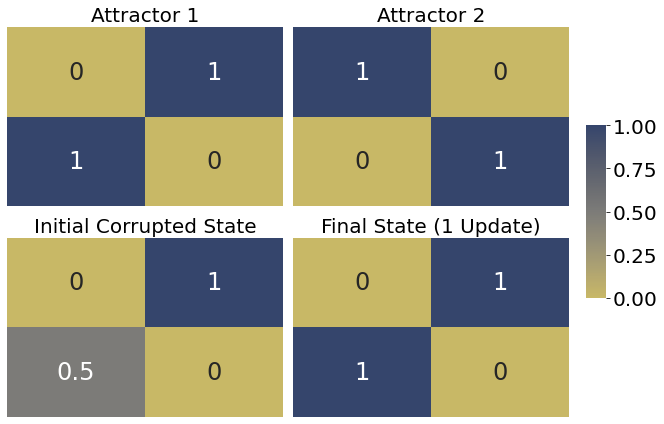

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


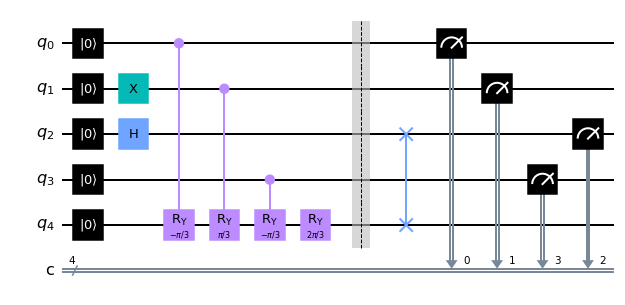

In [ ]:
def hop_weight_setting_2_attractors(u1,u2,length):
    wm = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            wm[i][j] = (1/2)*(u1[i]*u1[j]+u2[i]*u2[j])    
    return wm

def add_RUS1_JustRy_with_bias(qc,phis,control_registers,bias,qubit):
    num_ctrls = len(control_registers)
    for i in range(num_ctrls):
        qc.cry((phis[i]),control_registers[i],qubit) #control([num_ctrl_qubits, label, ctrl_state])
    qc.ry(bias,qubit)
    qc.barrier()

# create hopfield network in a single function using given attractors and initial state
def create_hopfield_simplified(initstate,attractor1,attractor2,shape_m,shape_n,RUSk,updates,num_tries,be,useNoise,nm,ploteach,fsize,cmp,nshots):
    n = len(attractor1)
    if(n != len(attractor2) or n != len(initstate)):
        print("Error: Attractors and input states must be the same length.")
        return
    wm = hop_weight_setting_2_attractors(attractor1,attractor2,n)
    thresholds = [0]*n
    qubits_to_update = updates
    if qubits_to_update == []:
        for i in range(n):
            if(initstate[i] == 0): # not(isinstance(initstate[i],int)) this can be changed depending on what convention we want to use
                qubits_to_update.append(i)
    k = RUSk
    
    a1_quantum = np.reshape(((0.5*np.array(attractor1))+0.5),[shape_m,shape_n])
    a2_quantum = np.reshape(((0.5*np.array(attractor2))+0.5),[shape_m,shape_n])
    init_quantum = np.reshape(((0.5*np.array(initstate))+0.5),[shape_m,shape_n])
    dfin1 = pd.DataFrame(a1_quantum)
    dfin2 = pd.DataFrame(a2_quantum)
    dfinit = pd.DataFrame(init_quantum)
    
    #gs_kw = dict(width_ratios=[1,1], height_ratios=[1,1])
    if(ploteach == True):
        num_plots = 3+len(qubits_to_update)
    else:
        num_plots = 4
    cols = 2
    rows = math.ceil(num_plots/cols)
    #rows = 2
    fig, axes = plt.subplots(figsize=(9,6),ncols=cols,nrows=rows,sharex=True,sharey=True)
    axs = [0] * (cols*rows)
    for i, ax in enumerate(axes.flat):
        ax.set_xlim([0,2])
        ax.set_ylim([0,2])
        axs[i] = ax
        #p1 = sns.heatmap(dfin1,cmap='PuBu',ax=ax)
    
    rfsize = fsize-4
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    p0 = sns.heatmap(dfin1,annot=True,annot_kws={"fontsize":fsize},cmap=cmp,cbar=0,cbar_ax=None,ax=axs[0],xticklabels="",yticklabels="",vmin=0, vmax=1)
    p1 = sns.heatmap(dfin2,annot=True,annot_kws={"fontsize":fsize},cmap=cmp,cbar=0,cbar_ax=None,ax=axs[1],xticklabels="",yticklabels="",vmin=0, vmax=1)
    p2 = sns.heatmap(dfinit,annot=True,annot_kws={"fontsize":fsize},cmap=cmp,cbar=0,cbar_ax=None,ax=axs[2],xticklabels="",yticklabels="",vmin=0, vmax=1)
    axs[0].set_title('Attractor 1',size=rfsize)
    axs[1].set_title('Attractor 2',size=rfsize)
    axs[2].set_title('Initial Corrupted State',size=rfsize)
    
    #init here
    num_qubits = n+k
    qc = QuantumCircuit(num_qubits,n)
    for q in range(num_qubits-1):
        qc.reset(q)
    for q in range(n):
        if(initstate[q] == 1):
            qc.x(q)
        elif(initstate[q] == 0): #not(isinstance(initstate[q],int))
            qc.h(q)
    
    tries = num_tries
    plot_num = 2
    num_updates = 0
    for trie in range(tries):    
        for updated_qubit in qubits_to_update:
            print("Updating qubit " + str(updated_qubit))
            qc.reset(num_qubits-1)
            controls = [i for i in range(n) if i!=updated_qubit]
            gamma = math.pi/(4*wm.max()*(n-1)+max(thresholds)) #n-1 is because we need size of control layer
            beta = (math.pi/4)+gamma*(thresholds[updated_qubit]-sum(wm[updated_qubit][controls]))
            add_RUS1_JustRy_with_bias(qc,4*gamma*wm[updated_qubit][controls],controls,2*beta,n)
            qc.swap(updated_qubit,n)
            plot_num = plot_num + 1
            num_updates = num_updates + 1
            if(ploteach == True):
                for q in range(n):
                    qc.measure(q,q)
                if useNoise == True:
                    result = execute(qc, backend=backend, shots=nshots, noise_model=nm).result()
                else:
                    result = execute(qc, backend=backend, shots=nshots).result()
                print("Result Completed")
                counts = result.get_counts()

                each_reg_count = np.zeros(n)
                for key, value in counts.items():
                    for i in range(n):
                        if key[n-i-1] == '1':
                            each_reg_count[i] = each_reg_count[i] + value
                #print(each_reg_count)
                reg_density = np.reshape((each_reg_count/nshots),[shape_m,shape_n])    
                dfdensity = pd.DataFrame(reg_density)
                #print(dfdensity)
                
                p_update = sns.heatmap(dfdensity,annot=True,annot_kws={"fontsize":fsize},cmap=cmp,ax=axs[plot_num],xticklabels="",yticklabels="") #square=True
                if(num_updates == len(qubits_to_update)):
                    if(num_updates == 1):
                        axs[plot_num].set_title('Final State (' + str(num_updates) + ' Update)', size=rfsize)
                    else:
                        axs[plot_num].set_title('Final State (' + str(num_updates) + ' Updates)', size=rfsize)
                elif(num_updates == 1):
                    axs[plot_num].set_title('State After ' + str(num_updates) + ' Update', size=rfsize)
                else:
                    axs[plot_num].set_title('State After ' + str(num_updates) + ' Updates', size=rfsize)
                cbar.ax.tick_params(labelsize=20)
    #print("We got out of the loops!")
    if(ploteach == False):
        for q in range(n):
            qc.measure(q,q)
        print("Executing...")
        if useNoise == True:
            result = execute(qc, backend=be, shots=nshots, noise_model=nm).result()
        else:
            result = execute(qc, backend=be, shots=nshots).result()
        print("Result Completed")
        counts = result.get_counts()

        each_reg_count = np.zeros(n)
        for key, value in counts.items():
            for i in range(n):
                if key[n-i-1] == '1':
                    each_reg_count[i] = each_reg_count[i] + value
        #print(each_reg_count)
        reg_density = np.reshape((each_reg_count/nshots),[shape_m,shape_n])    
        dfdensity = pd.DataFrame(reg_density)
        #print(dfdensity)
        p_all = sns.heatmap(dfdensity,annot=True,annot_kws={"fontsize":fsize},cmap=cmp,cbar_ax=cbar_ax,ax=axs[3],xticklabels="",yticklabels="",vmin=0, vmax=1)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        if(num_updates == 1):
            axs[3].set_title('Final State (' + str(num_updates) + ' Update)', size=rfsize)
        else:
            axs[3].set_title('Final State (' + str(num_updates) + ' Updates)', size=rfsize)
    plt.tight_layout(rect=[0, 0, .9, 1])
    plt.show()
    fig.savefig('test.png', bbox_inches='tight',dpi=600)
    
    return qc # return full hop quantum circuit

    

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito')
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)
#noise_model = "stop being annoying"

cividisBig = cm.get_cmap('cividis_r', 512)
newcmp = ListedColormap(cividisBig(np.linspace(0.2, 0.8, 256)))

# 2x2 for Hardware
initial = [-1,1,0,-1]
in1 = [-1,1,1,-1]
in2 = [1,-1,-1,1] 

# 3x3 Corrupted C,Y
#initial = [0,0,0,1,-1,-1,-1,1,1]
#in1 = [-1,1,1,1,-1,-1,-1,1,1] #C
#in2 = [1,-1,1,-1,1,-1,-1,1,-1] #Y

# 4x4 Corrupted Cross Hatches
#initial = [-1,1,-1,1,1,-1,0,-1,-1,1,-1,1,1,0,1,-1]
#in1 = [-1,1,-1,1,1,-1,1,-1,-1,1,-1,1,1,-1,1,-1] 
#in2 = [1,-1,1,-1,-1,1,-1,1,1,-1,1,-1,-1,1,-1,1]

# 4x4 Corrupted C,X - fix [1,6,8,11,12,14]
#initial = [1,0,1,1,1,-1,0,-1,0,-1,-1,0,0,1,0,1] # 4x4 corrupted C
#in1 = [1,1,1,1,1,-1,-1,-1,1,-1,-1,-1,1,1,1,1] # 4x4 C
#in2 = [1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1] # 4x4 X

# 4x4 Flipped Bits C,X - fix [2,5,8,10,13]
#initial = [1,-1,1,1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1] # 4x4 Bit Flipped C
#in1 = [1,1,1,1,1,-1,-1,-1,1,-1,-1,-1,1,1,1,1] # 4x4 C
#in2 = [1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1] # 4x4 X

# 4x5
#initial = [1,0,1,1,1,-1,0,-1,0,-1,-1,0,0,1,0,1,1,1,1,1] # 4x4 corrupted C
#in1 = [1,1,1,1,1,-1,-1,-1,1,-1,-1,-1,1,1,1,1,1,1,1,1] # 4x4 C
#in2 = [1,-1,-1,1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1,1,1,1,1] # 4x4 X

# 5x5 Cross Hatches
#initial = [-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,0,0,1,-1,1,-1,1,-1,1,-1,1,-1]
#in1 = [-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1] 
#in2 = [1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1] # 5x5 cross hatches

hop = create_hopfield_simplified(initial,in1,in2,2,2,1,[2],1,backend,False,noise_model,False,24,newcmp,8192) #0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15

hop.draw(output='mpl')

In [ ]:
################################################################################################################################
# Testing Effective Memory Capacity
################################################################################################################################

# Generic weight setting for any number of attractors of any given length
def hop_weight_setting_X_attractors(us):
    X = len(us)
    length = len(us[0])
    wm = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            for u in us:
                wm[i][j] = wm[i][j] + u[i]*u[j]
            wm[i][j] = wm[i][j]/X
    return wm

# create hopfield network in a single function using given attractors and initial state
def create_hopfield_simplified_forCapacityCalc_noresets(initstate,attractors,updates,be,useNoise,nm,nshots):
    n = len(attractors[0])
    if(n != len(initstate)):
        print("Error: Attractors and input states must be the same length.")
        return
    wm = hop_weight_setting_X_attractors(attractors)
    thresholds = [0]*n
    qubits_to_update = updates
    
    attractors_quantum = []
    for attractor in attractors:
        attractors_quantum.append(0.5*np.array(attractor)+0.5)
    init_quantum = 0.5*np.array(initstate)+0.5
    
    num_qubits = n+len(qubits_to_update)
    qc = QuantumCircuit(num_qubits,n)
    for q in range(num_qubits):
        qc.reset(q)
    for q in range(n):
        if(initstate[q] == 1):
            qc.x(q)
        elif(initstate[q] == 0):
            qc.h(q)
    
    num_updates = 0  
    for updated_qubit in qubits_to_update:
        controls = [i for i in range(n) if i!=updated_qubit]
        gamma = math.pi/(4*wm.max()*(n-1)+max(thresholds)) #n-1 is because we need size of control layer
        beta = (math.pi/4)+gamma*(thresholds[updated_qubit]-sum(wm[updated_qubit][controls]))
        add_RUS1_JustRy_with_bias(qc,4*gamma*wm[updated_qubit][controls],controls,2*beta,n+num_updates)
        qc.swap(updated_qubit,n+num_updates)
        num_updates = num_updates + 1
    
    for q in range(n):
        qc.measure(q,n-q-1) # perform measurements backwards to get around order convention
    #print("Executing...")
    if useNoise == True:
        result = execute(qc, backend=be, shots=nshots, noise_model=nm).result()
    else:
        job = execute(qc, backend=be, shots=nshots)
        result = job.result()
     
    counts = result.get_counts()

    each_reg_count = np.zeros(n)
    for key, value in counts.items():
        for i in range(n):
            if key[i] == '1':
                each_reg_count[i] = each_reg_count[i] + value
    reg_density = each_reg_count/nshots    
    
    return counts, reg_density


def create_hopfield_simplified_forCapacityCalc_withresets(initstate,attractors,updates,be,useNoise,nm,nshots):
    n = len(attractors[0])
    if(n != len(initstate)):
        print("Error: Attractors and input states must be the same length.")
        return
    wm = hop_weight_setting_X_attractors(attractors)
    thresholds = [0]*n
    qubits_to_update = updates
    
    attractors_quantum = []
    for attractor in attractors:
        attractors_quantum.append(0.5*np.array(attractor)+0.5)
    init_quantum = 0.5*np.array(initstate)+0.5
    
    num_qubits = n+1
    qc = QuantumCircuit(num_qubits,n)
    for q in range(num_qubits):
        qc.reset(q)
    for q in range(n):
        if(initstate[q] == 1):
            qc.x(q)
        elif(initstate[q] == 0):
            qc.h(q)
    
    num_updates = 0  
    for updated_qubit in qubits_to_update:
        #print("Updating qubit " + str(updated_qubit))
        qc.reset(num_qubits-1)
        controls = [i for i in range(n) if i!=updated_qubit]
        gamma = math.pi/(4*wm.max()*(n-1)+max(thresholds)) #n-1 is because we need size of control layer
        beta = (math.pi/4)+gamma*(thresholds[updated_qubit]-sum(wm[updated_qubit][controls]))
        add_RUS1_JustRy_with_bias(qc,4*gamma*wm[updated_qubit][controls],controls,2*beta,n)
        qc.swap(updated_qubit,n)
        num_updates = num_updates + 1
    
    for q in range(n):
        qc.measure(q,n-q-1) # perform measurements backwards to get around order convention
    #print("Executing...")
    if useNoise == True:
        result = execute(qc, backend=be, shots=nshots, noise_model=nm).result()
    else:
        job = execute(qc, backend=be, shots=nshots)
        #job_monitor(job)
        result = job.result()
     
    counts = result.get_counts()

    each_reg_count = np.zeros(n)
    for key, value in counts.items():
        for i in range(n):
            if key[i] == '1':
                each_reg_count[i] = each_reg_count[i] + value
    reg_density = each_reg_count/nshots    
    
    return counts, reg_density

def create_hopfield_simplified_forCapacityCalc_parallel(initstate,attractors,updates,be,useNoise,nm,nshots):
    n = len(attractors[0])
    if(n != len(initstate)):
        print("Error: Attractors and input states must be the same length.")
        return
    wm = hop_weight_setting_X_attractors(attractors)
    thresholds = [0]*n
    qubits_to_update = updates
    
    attractors_quantum = []
    for attractor in attractors:
        attractors_quantum.append(0.5*np.array(attractor)+0.5)
    init_quantum = 0.5*np.array(initstate)+0.5
    
    num_qubits = 2*n
    qc = QuantumCircuit(num_qubits,n)
    for q in range(num_qubits):
        qc.reset(q)
    for q in range(n):
        if(initstate[q] == 1):
            qc.x(q)
        elif(initstate[q] == 0):
            qc.h(q)
    
    num_updates = 0  
    for updated_qubit in qubits_to_update:
        #print("Updating qubit " + str(updated_qubit))
        controls = [i for i in range(n) if i!=updated_qubit]
        gamma = math.pi/(4*wm.max()*(n-1)+max(thresholds)) #n-1 is because we need size of control layer
        beta = (math.pi/4)+gamma*(thresholds[updated_qubit]-sum(wm[updated_qubit][controls]))
        add_RUS1_JustRy_with_bias(qc,4*gamma*wm[updated_qubit][controls],controls,2*beta,n+num_updates)
        num_updates = num_updates + 1
    
    for q in range(n):
        qc.measure(n+q,n-qubits_to_update[q]-1) # perform measurements backwards to get around order convention
    #print("Executing...")
    if useNoise == True:
        result = execute(qc, backend=be, shots=nshots, noise_model=nm).result()
    else:
        job = execute(qc, backend=be, shots=nshots)
        #job_monitor(job)
        result = job.result()
    
    #print("Result Completed")    
    counts = result.get_counts()

    each_reg_count = np.zeros(n)
    for key, value in counts.items():
        for i in range(n):
            if key[i] == '1':
                each_reg_count[i] = each_reg_count[i] + value
    #print(each_reg_count)
    reg_density = each_reg_count/nshots    
    
    return counts, reg_density


def generate_memories_and_probe(m,n):
    size = 2**n
    possible_mems = np.arange(size)
    binary_mems = np.empty(shape=(0),dtype=str)
    for pm in possible_mems:
        binary_mems = np.append(binary_mems,["{0:b}".format(pm).zfill(n)],0)
    chosen_ms = np.random.choice(binary_mems, size=m, replace=False)
    memories = np.empty((0,n))
    for m in chosen_ms:
        hop_m = np.empty((0))
        for i in m:
            hop_m = np.append(hop_m,[2*(int(i,2))-1],0)
        memories = np.append(memories,[hop_m],0)
    
    generate_again = True
    p_limit = 0.01*n
    while(generate_again):
        probe = np.random.choice([-1,1],n)
        best = len(probe)+1
        bad = False
        target = np.array([])
        for memory in memories:
        #print(memory)
            p = np.count_nonzero(memory-probe)
            if(p<best):
                best = p
                target = memory
            elif(p==best):
                bad = True
        if(not(bad or (best>=p_limit))):
            generate_again = False
    
    return memories, probe, target

def generate_memories_and_probe_independent(m,n):
    identity = np.identity(n)
    rng = np.arange(n)
    indices = np.random.choice(rng, size=m, replace=False)
    memories = identity[indices,:]
    probe_index = np.random.choice(rng)
    probe = identity[probe_index,:]
    return memories, probe, target

def convert_states_to_quantum_and_string(states):
    quantum_states = np.empty((0,len(states[0])))
    str_states = np.array([])
    for state in states:
        quantum_state = (0.5*state+0.5).astype(int)
        quantum_states = np.append(quantum_states,[(0.5*state+0.5).astype(int)],0)
        str_states = np.append(str_states, np.array2string(quantum_state,separator='')[1:-1])

    return quantum_states, str_states



In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 1000
num_updates = [6] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [4] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1, 2, 3, 4] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results = np.append(accuracy_results,[[n,m,num_ran,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran,num_update]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            # return accuracy_results
print(accuracy_results)    

n = 4, m = 1, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 4, m = 2, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 0.781
Most Often Occurance Accuracy: 0.776
Total Average Density: 0.801872314453125
Total Percent Exact Accuracy: 0.472619140625
n = 4, m = 3, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 0.496
Most Often Occurance Accuracy: 0.512
Total Average Density: 0.71721728515625
Total Percent Exact Accuracy: 0.31323828125
n = 4, m = 4, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 0.436
Most Often Occurance Accuracy: 0.444
Total Average Density: 0.676662109375
Total Percent Exact Accuracy: 0.2377939453125
[[4.00000000e+00 1.00000000e+00 1.00000000e+03 1.00000000e+00
  1.00000000e+00 1.00000000e+00 6.00000000e+00]
 [4.00000000e+00 2.00000000e+00 1.00000000e+03 7.81000000e-01
  8.01872314e-01 4.72619141e-01 6.000

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 10
num_updates = [5,6] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [4] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results = np.append(accuracy_results,[[n,m,num_ran,num_update,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            result = pd.DataFrame(accuracy_results)
pd.DataFrame(accuracy_results).to_csv("EXP: "+ "n="+ str(ns)+ "| m="+ str(ms)+".csv")
            # return accuracy_results
print(accuracy_results)    

n = 4, m = 1, num_ran = 10, num_updates = 5
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 4, m = 1, num_ran = 10, num_updates = 6
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
[[ 4.  1. 10.  5.  1.  1.  1.]
 [ 4.  1. 10.  6.  1.  1.  1.]]


In [ ]:
with np.printoptions(threshold=np.inf):
    print(accuracy_results)

[[   4.    1. 1000.    1.    1.    1.    4.]]


In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 500
num_updates = [12,16,18,20,22] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [12] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [2,4,6,8,10,12,14] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results = np.append(accuracy_results,[[n,m,num_ran,num_update,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            result = pd.DataFrame(accuracy_results)
pd.DataFrame(accuracy_results).to_csv("EXP: "+ "n="+ str(ns)+ "| m="+ str(ms)+".csv")
            # return accuracy_results
print(accuracy_results)    

n = 12, m = 2, num_ran = 500, num_updates = 12
Percent Correct Majority Vote: 0.99
Most Often Occurance Accuracy: 0.996
Total Average Density: 0.8728403320312498
Total Percent Exact Accuracy: 0.25448046875
n = 12, m = 2, num_ran = 500, num_updates = 16
Percent Correct Majority Vote: 0.994
Most Often Occurance Accuracy: 0.996
Total Average Density: 0.840183919270833
Total Percent Exact Accuracy: 0.1942890625
n = 12, m = 2, num_ran = 500, num_updates = 18
Percent Correct Majority Vote: 0.988
Most Often Occurance Accuracy: 0.994
Total Average Density: 0.8269816080729164
Total Percent Exact Accuracy: 0.174123046875
n = 12, m = 2, num_ran = 500, num_updates = 20
Percent Correct Majority Vote: 0.972
Most Often Occurance Accuracy: 0.996
Total Average Density: 0.8139085286458334
Total Percent Exact Accuracy: 0.158392578125
n = 12, m = 2, num_ran = 500, num_updates = 22
Percent Correct Majority Vote: 0.958
Most Often Occurance Accuracy: 0.988
Total Average Density: 0.7967032877604171
Total Perc

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 500
num_updates = [5,6] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [4] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results = np.append(accuracy_results,[[n,m,num_ran,num_update,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            result = pd.DataFrame(accuracy_results)
pd.DataFrame(accuracy_results).to_csv("EXP: "+ "n="+ str(ns)+ "| m="+ str(ms)+".csv")
            # return accuracy_results
print(accuracy_results)    

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 500
num_updates = [5,6,8,9] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [5] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1,2,3,4,5,6] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results = np.append(accuracy_results,[[n,m,num_ran,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran,num_update]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran

print(accuracy_results)    

n = 5, m = 1, num_ran = 1000, num_updates = 5
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 5, m = 1, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 5, m = 1, num_ran = 1000, num_updates = 7
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 5, m = 1, num_ran = 1000, num_updates = 8
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 5, m = 2, num_ran = 1000, num_updates = 5
Percent Correct Majority Vote: 0.895
Most Often Occurance Accuracy: 0.898
Total Average Density: 0.8551136718750002
Total Percent Exact Accuracy: 0.4999072265625
n = 5, m = 2, num_ran = 1000, num_updates = 6
Percent Correct Majority Vote: 0.887
M

In [ ]:
accuracy_results[]

array([[5.00000000e+00, 1.00000000e+00, 1.00000000e+03, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 5.00000000e+00],
       [5.00000000e+00, 1.00000000e+00, 1.00000000e+03, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 6.00000000e+00],
       [5.00000000e+00, 1.00000000e+00, 1.00000000e+03, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 7.00000000e+00],
       [5.00000000e+00, 1.00000000e+00, 1.00000000e+03, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 8.00000000e+00],
       [5.00000000e+00, 2.00000000e+00, 1.00000000e+03, 8.95000000e-01,
        8.55113672e-01, 4.99907227e-01, 5.00000000e+00],
       [5.00000000e+00, 2.00000000e+00, 1.00000000e+03, 8.87000000e-01,
        8.35075781e-01, 4.67466797e-01, 6.00000000e+00],
       [5.00000000e+00, 2.00000000e+00, 1.00000000e+03, 8.51000000e-01,
        8.14323633e-01, 4.24709961e-01, 7.00000000e+00],
       [5.00000000e+00, 2.00000000e+00, 1.00000000e+03, 8.48000000e-01,
        7.93193945e-01, 3

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 1000
num_updates = [10] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [8] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1, 2 , 4, 8 , 10 , 12] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results_8 = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results_8 = np.append(accuracy_results_8,[[n,m,num_ran,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran,num_update]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            # return accuracy_results
print(accuracy_results_8)    

n = 8, m = 1, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 8, m = 2, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 0.948
Most Often Occurance Accuracy: 0.966
Total Average Density: 0.8424002685546875
Total Percent Exact Accuracy: 0.3280224609375
n = 8, m = 4, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 0.475
Most Often Occurance Accuracy: 0.483
Total Average Density: 0.727163330078125
Total Percent Exact Accuracy: 0.102
n = 8, m = 8, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 0.235
Most Often Occurance Accuracy: 0.234
Total Average Density: 0.6740064697265625
Total Percent Exact Accuracy: 0.0475224609375
n = 8, m = 10, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 0.183
Most Often Occurance Accuracy: 0.21
Total Average Density: 0.6693028564453125
Total Percent Exact Accuracy: 0.04226855468

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 1000
num_updates = [7,8,9,10,12,14] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [7] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1, 2 , 4, 8 , 10 , 12] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results_7 = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results_7 = np.append(accuracy_results_7,[[n,m,num_ran,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran,num_update]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            # return accuracy_results
print(accuracy_results_7)    

n = 7, m = 1, num_ran = 1000, num_updates = 7
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 7, m = 1, num_ran = 1000, num_updates = 8
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 7, m = 1, num_ran = 1000, num_updates = 9
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 7, m = 1, num_ran = 1000, num_updates = 10
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 7, m = 1, num_ran = 1000, num_updates = 12
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 1.0
Total Average Density: 1.0
Total Percent Exact Accuracy: 1.0
n = 7, m = 1, num_ran = 1000, num_updates = 14
Percent Correct Majority Vote: 1.0
Most Often Occurance Accuracy: 

In [ ]:
## capacity experiments #########################################################################
#################################################################################################

provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_quito') #ibmq_16_melbourne used originally, now retired
backend = Aer.get_backend('qasm_simulator')
noise_model = NoiseModel.from_backend(device)

shots = 1024
num_tests = 1000
num_updates = [3,4,5] #[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ns = [3] #4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ms = [1, 2 , 4, 8 ] #2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy_results_3 = np.empty((0,7))
for n in ns:
    for m in ms:
        for num_update in num_updates:
            if (num_update < n) or (num_update > 2*n):
                print("continued")
                continue
            total_accuracy = 0
            correct_majorities = 0
            most_often_accuracy = 0
            num_ran = 0
            total_density_accuracy = 0
            while(num_ran < num_tests):
                memories, probe, target = generate_memories_and_probe(m,n)
                num_ran = num_ran + 1
                qubit_list = np.arange(len(probe))
                update_list = np.random.choice(qubit_list, size=num_update, replace=True)
                #print(update_list)
                quantum_target = (0.5*target+0.5).astype(int)
                str_target = np.array2string(quantum_target,separator='')[1:-1]
                counts, density = create_hopfield_simplified_forCapacityCalc_withresets(probe,memories,update_list,backend,False,noise_model,shots)
                #if(num_ran%10==0):
                #    print(n,m,num_ran)
                if str_target in counts:
                    accuracy = counts[str_target]/shots
                else:
                    accuracy = 0
                
                most_often = max(counts, key=counts.get)
                
                density_accuracy = 0
                for i in range(len(quantum_target)):
                    if quantum_target[i] == 0:
                        density_accuracy = density_accuracy + (1-density[i])
                    else:
                        density_accuracy = density_accuracy + density[i]
                total_density_accuracy = total_density_accuracy + (density_accuracy/n)
                majority_vote_result = np.round(density).astype(int)
                quantum_probe = (0.5*probe+0.5).astype(int)
                if((quantum_target == majority_vote_result).all()):
                    correct_majorities = correct_majorities + 1
                if(str_target == most_often):
                    most_often_accuracy = most_often_accuracy + 1
                total_accuracy = total_accuracy + accuracy
            print('n = ' + str(n) + ', m = ' + str(m) + ', num_ran = ' + str(num_ran) + ', num_updates = ' + str(num_update))
            print('Percent Correct Majority Vote: ' + str(correct_majorities/num_ran))
            print('Most Often Occurance Accuracy: ' + str(most_often_accuracy/num_ran))
            print('Total Average Density: ' + str(total_density_accuracy/num_ran))
            print('Total Percent Exact Accuracy: ' + str(total_accuracy/num_ran))
            accuracy_results_3 = np.append(accuracy_results_3,[[n,m,num_ran,correct_majorities/num_ran,total_density_accuracy/num_ran,total_accuracy/num_ran,num_update]],0) #,oneOffAccuracy/num_ran,twoOffAccuracy/num_ran
            # return accuracy_results
print(accuracy_results_3)    